In [2]:

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import matplotlib.pyplot as plt
import numpy as np

from qutip import sesolve

from src.modules.atom_config import RbAtom
from src.modules.ketbra_config import RbKetBras


In [3]:
#List the groundstates to be included in the simulation

atomStates = {
    "g1M": 0,
    #"g1": 1,
    #"g1P": 1,  # F=1,mF=-1,0,+1 respectively
    "g2MM": 1,
    #"g2M": 4,
    #"g2": 3,
    #"g2P": 6,
    #"g2PP": 7  # F=2,mF=-2,..,+2 respectively
}

'''
atomStates = {
    "g1M": 0,
    "g2MM": 1,
}'''



# List the excited levels to include in the simulation. the _d1 levels correspond to the D1 line levels, the other levels are by default the d2 levels
xlvls = [
#'x0',
#'x1M','x1','x1P',
#'x2MM','x2M','x2','x2P','x2PP',
#'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP',
#'x1M_d1','x1_d1','x1P_d1',
#'x2MM_d1','x2M_d1','x2_d1','x2P_d1','x2PP_d1'
]

#configure the atm state dictionary such that it includes the desired excited states, this includes the desired ground and excited states as arguments,
# as well as a boolean for whether to include the photonic Hilbert space

kb_class=RbKetBras(atomStates, xlvls, False)

#precompute ketbras for speed
ketbras=kb_class.getrb_ketbras()

In [4]:
#specify system b field groundstate splitting in MHz
bfieldsplit = '0p07'
#configure rb atom with desired CG coefficients and splittings
rb_atom = RbAtom(bfieldsplit, kb_class)

rotation_number=2
det_centre=-100000
rise_time=0.075

#maybe make this a list to run through
amp_scaling=1.0
number_of_rabi_cycles=2
pulse_length=1.0

#first calibrate amp/time then phase

In [5]:
#first laser is always from F=2 and second from F=1


if rotation_number==2:
    cg_1=rb_atom.CG_d1g2x1
    pol_1="pi"
    det_zeeman_1=0

    cg_2=rb_atom.CG_d1g1Px1
    pol_2="sigmaM"
    det_zeeman_2=rb_atom.deltaZ

    psi_0= kb_class.get_ket_atomic('g2MM')
    #psi_des= 1/np.sqrt(2)*(kb_class.get_ket_atomic('g1P')-kb_class.get_ket_atomic('g2MM'))

    coherence_indices=[2,3]





delta_1 -628317.3578567012
delta_2 -628319.1171485872
------------------
Delta -628318.2375026443
delta 1.7592918860027567
------------------
omega_1 max: (6882.491372335378+0j)
omega_2 max: (2809.925897004044+0j)
effective omega_1_max: (0.005476915169366234+0j)
effective omega_2_max: (0.0022360690246494863+0j)
-----------------


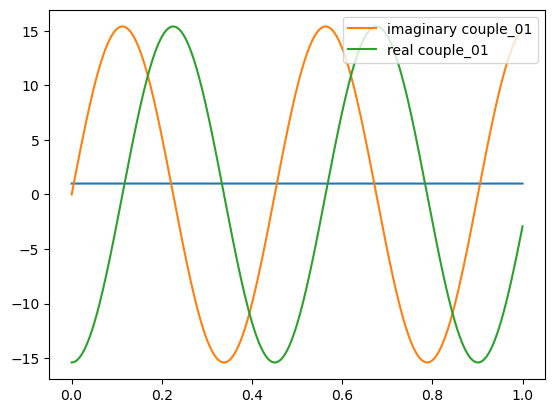

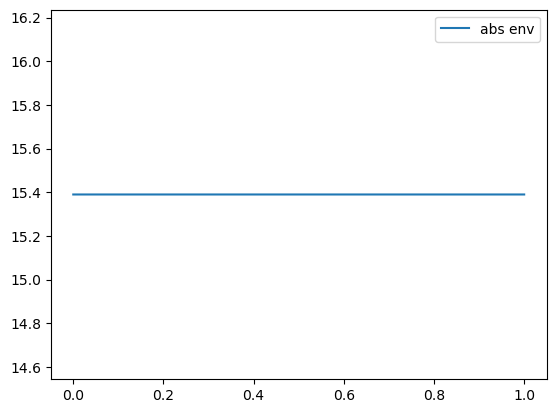

-----------------


In [6]:
#Define the laser pulse parameters
two_phot_det=0.0
#The pulse is a flattop pulse with a blackman window
pulse_time=np.linspace(0,pulse_length,10000)
#pulse_1, _=create_blackman(pulse_time, 0, 1, 1)
#pulse_1=create_flattop_blackman(pulse_time,1, rise_time, rise_time)
pulse_1=np.ones(pulse_time.shape)
#pulse_1, pulse_2=create_blackman(pulse_time, 0,1, 1)
det_1=(det_centre*2*np.pi)+det_zeeman_1
amp_1=amp_scaling*np.sqrt(2*np.abs(det_centre))*2*np.pi/cg_1
pulse_2 = pulse_1
plt.plot(pulse_time, pulse_2)
det_2=det_1-two_phot_det*2*np.pi-rb_atom.getrb_gs_splitting()+det_zeeman_2
amp_2 = amp_scaling * np.sqrt(2 * np.abs(det_centre)) * 2 * np.pi / cg_2
ham, args=rb_atom.gen_H_FarDetuned_Raman_PulsePair_D1(ketbras, atomStates, det_1, det_2,pol_1, pol_2, amp_1, amp_2,pulse_time, pulse_1, pulse_2)

#add decay ops
c_op_list=[]
#c_op_list+=rb_atom.spont_em_ops_far_detuned(atomStates,pol_1,amp_1,det_1)
#c_op_list += rb_atom.spont_em_ops_far_detuned(atomStates, pol_2, amp_2, det_2)

In [7]:
output_mesolve = sesolve(ham, psi_0, pulse_time)

Text(0.5, 1.0, 'State Populations')

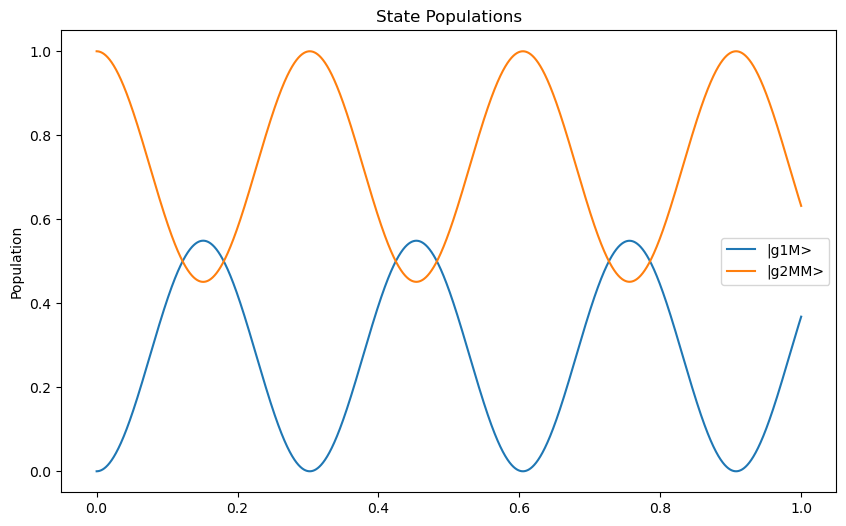

In [8]:
# Assume output_mesolve.states is a list of Qobj kets of shape (4, 1)
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)

state_labels = list(atomStates.keys())  # e.g., ['g', 'e', 'r', 'rr']

# Plot state populations (amplitudes squared)
for i in range(len(atomStates)):
    populations = [np.abs(state[i, 0])**2 for state in output_mesolve.states]
    axes.plot(pulse_time, populations, label=f"|{state_labels[i]}>")

axes.set_ylabel("Population")
axes.legend()
axes.set_title("State Populations")
